<a href="https://colab.research.google.com/github/xChoco-rmdn/ml-satellite/blob/main/notebooks/Satellite_Cloud_Nowcasting_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Cloud Nowcasting Project: Himawari Imagery Analysis

This notebook demonstrates the entire workflow for the Satellite Cloud Nowcasting project, which uses Himawari-8/9 satellite data for the NTB region.

## Project Overview
- **Domain**: Meteorological Nowcasting
- **Focus**: Cloud Forecasting in Central Indonesia (NTB Region)
- **Satellite**: Himawari-8/9 Band 13 (10.4 µm Infrared)
- **Prediction Horizon**: 0-5 hours

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone the repository
!git clone https://github.com/xChoco-rmdn/ml-satellite.git

# Change to project directory
%cd ml-satellite

# Install requirements
!pip install -r requirements.txt

Cloning into 'ml-satellite'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 132 (delta 54), reused 100 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 260.41 KiB | 16.28 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/ml-satellite
Obtaining file:///content/ml-satellite (from -r requirements.txt (line 13))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.3/398.3 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.4/658.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1. Setup and Imports

In [10]:
# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import project modules
from src.logger import logger
from src.exception import CustomException
from src.components.data_ingestion import DataIngestion
from src.components.data_transformations import DataTransformation
from src.components.model import CloudNowcastingModel
from src.components.model_evaluation import ModelEvaluator
from src.pipeline.train_pipeline import TrainPipeline
from src.pipeline.predict_pipeline import PredictionPipeline

# Configure TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logger.info(f"Found {len(gpus)} GPU(s), memory growth enabled")
    except RuntimeError as e:
        logger.warning(f"Memory growth setting failed: {str(e)}")

## 2. Data Ingestion

In [11]:
# Create directories if they don't exist
# os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/processed/samples', exist_ok=True)

In [12]:
# Initialize data ingestion
data_ingestion = DataIngestion()

try:
    # List all Himawari files in the raw data directory
    import glob
    satellite_files = glob.glob(os.path.join("/content/drive/MyDrive/Himawari_NTB_202504", "H09_B13_Indonesia_*.nc"))

    if not satellite_files:
        logger.warning("No Himawari-9 Band 13 files found in data/raw directory.")
        logger.info("Using sample data for demonstration...")

        # Create sample data if real data is not available
        # This is for demonstration purposes only
        def create_sample_data():
            # Create synthetic satellite data for demonstration
            # Simulating cloud movement patterns
            height, width = 400, 400  # Image dimensions
            time_steps = 200  # Total time steps

            # Create moving cloud patterns with gaussian blobs
            data = np.zeros((time_steps, height, width))

            # Add several moving cloud patterns
            for t in range(time_steps):
                # Base temperature field (higher values = colder cloud tops)
                data[t] = np.random.normal(220, 10, (height, width))

                # Add moving cloud clusters
                for i in range(5):
                    x = int((width/2) + (width/4) * np.sin(t/30 + i))
                    y = int((height/2) + (height/4) * np.cos(t/20 + i))

                    # Create gaussian cloud
                    for dy in range(-50, 50):
                        for dx in range(-50, 50):
                            if 0 <= y+dy < height and 0 <= x+dx < width:
                                dist = np.sqrt(dx**2 + dy**2)
                                if dist < 50:
                                    # Colder cloud top temperature (higher values)
                                    data[t, y+dy, x+dx] = 280 - dist*1.2

            # Split into train and test
            train_data = data[:160]
            test_data = data[160:]

            # Save the data
            np.save("data/train/train_data_20250401_0000_to_20250425_0100.npy", train_data)
            np.save("data/test/test_data_20250425_0110_to_20250501_0000.npy", test_data)

            logger.info("Sample data created successfully")
            return True

        create_sample_data()
    else:
        # Process real satellite data
        logger.info(f"Found {len(satellite_files)} satellite files. Processing...")
        ingestion_result = data_ingestion.initiate_data_ingestion(satellite_files)
        logger.info(f"Data ingestion completed. Files saved:\n{ingestion_result}")

except Exception as e:
    logger.error(f"Error in data ingestion: {str(e)}")

## 3. Data Transformation

In [13]:
# Initialize data transformation
data_transformation = DataTransformation()

try:
    # Load training and test data
    logger.info("Loading training and test data...")
    train_data = np.load("data/train/train_data_20250401_0000_to_20250425_0100.npy")
    test_data = np.load("data/test/test_data_20250425_0110_to_20250501_0000.npy")

    logger.info(f"Training data shape: {train_data.shape}")
    logger.info(f"Test data shape: {test_data.shape}")

    # Transform data
    logger.info("Transforming data...")
    (X_train, y_train), (X_test, y_test) = data_transformation.initiate_data_transformation(
        train_data, test_data
    )

    # Display results
    logger.info(f"Transformed data shapes:")
    logger.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    logger.info(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Save sample sequences for visualization
    sample_dir = "data/processed/samples"
    np.save(f"{sample_dir}/sample_input_sequence.npy", X_train[0])
    np.save(f"{sample_dir}/sample_target_sequence.npy", y_train[0])

except Exception as e:
    logger.error(f"Error in data transformation: {str(e)}")

### Visualize Sample Sequence

Let's visualize a sample input and target sequence to better understand the data.

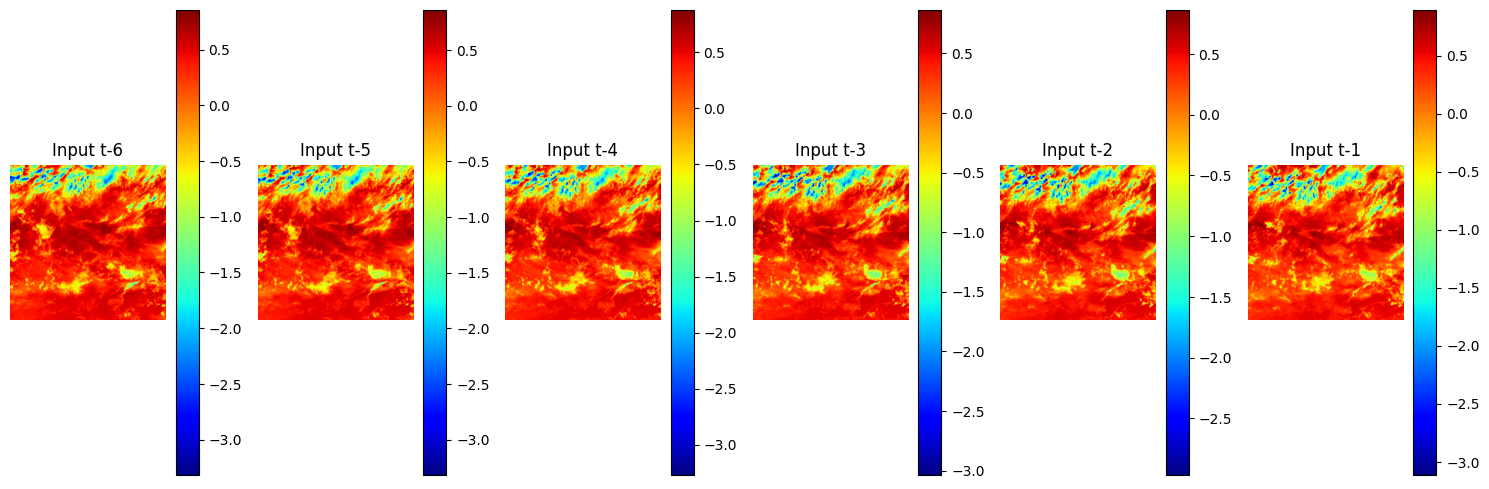

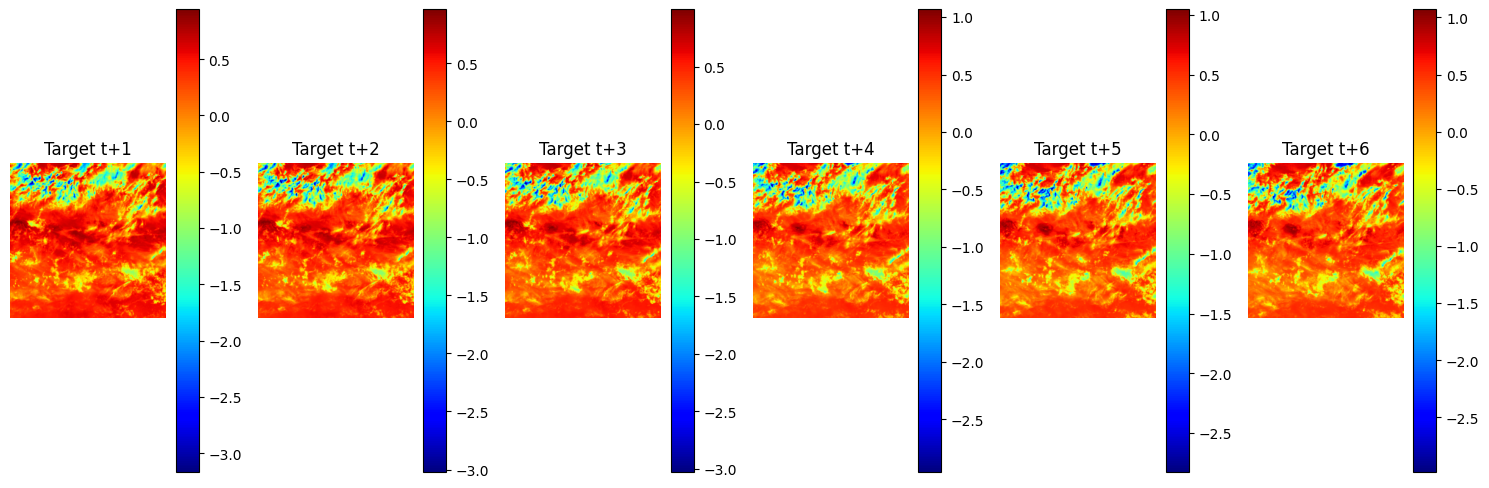

In [14]:
# Visualize a sample sequence
try:
    # Load sample sequence
    X_sample = np.load(f"{sample_dir}/sample_input_sequence.npy")
    y_sample = np.load(f"{sample_dir}/sample_target_sequence.npy")

    # Plot input sequence
    plt.figure(figsize=(15, 5))
    for i in range(X_sample.shape[0]):
        plt.subplot(1, X_sample.shape[0], i+1)
        plt.imshow(X_sample[i], cmap='jet')
        plt.title(f'Input t-{X_sample.shape[0]-i}')
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot target sequence
    plt.figure(figsize=(15, 5))
    for i in range(y_sample.shape[0]):
        plt.subplot(1, y_sample.shape[0], i+1)
        plt.imshow(y_sample[i], cmap='jet')
        plt.title(f'Target t+{i+1}')
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"Error visualizing sample sequence: {str(e)}")

## 4. Model Building and Training
Train the ConvLSTM model for cloud nowcasting.

In [15]:
# Option 1: Quick Model Test
# This is useful for testing the model architecture
def test_model_architecture():
    try:
        # Initialize model
        model_builder = CloudNowcastingModel()
        model = model_builder.build_model()

        # Print model summary
        model.summary()

        # Test with sample data
        X_sample = np.load(f"{sample_dir}/sample_input_sequence.npy")
        y_sample = np.load(f"{sample_dir}/sample_target_sequence.npy")

        # Add channel dimension if needed
        if len(X_sample.shape) == 3:
            X_sample = np.expand_dims(X_sample, axis=-1)
        if len(y_sample.shape) == 3:
            y_sample = np.expand_dims(y_sample, axis=-1)

        # Add batch dimension
        X_sample = np.expand_dims(X_sample, axis=0)
        y_sample = np.expand_dims(y_sample, axis=0)

        # Test forward pass
        test_output = model.predict(X_sample)
        logger.info(f"Test output shape: {test_output.shape}")

        # Test one training step
        history = model_builder.train_model(
            model,
            train_data=(X_sample, y_sample),
            valid_data=None,
            callbacks=None
        )

        logger.info("Model architecture test completed successfully!")
        return model

    except Exception as e:
        logger.error(f"Error testing model architecture: {str(e)}")
        return None

# Run quick model test
model = test_model_architecture()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 256, 256, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 128, 128, 1) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 6, 128, 128,    │        38,144 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 6, 64, 64, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 6, 64, 64, 64)  │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 6, 64, 64, 64)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 6, 128, 128,    │             0 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 6, 128, 128,    │       110,720 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 6, 256, 256,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 6, 256, 256, 1) │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,529 (2.54 MB)

 Trainable params: 666,145 (2.54 MB)

 Non-trainable params: 384 (1.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - loss: 2.0608 - mae: 1.0255

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 2.0608 - mae: 1.0255 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 9.6377 - mae: 2.5559 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 1.0100 - mae: 0.7532

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 1.0100 - mae: 0.7532 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 0.7200 - mae: 0.5936

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: 0.7200 - mae: 0.5936 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.4871 - mae: 0.5108

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.4871 - mae: 0.5108 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4768 - mae: 0.5156

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.4768 - mae: 0.5156 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.4165 - mae: 0.4791

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.4165 - mae: 0.4791 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3450 - mae: 0.4260

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.3450 - mae: 0.4260 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.3372 - mae: 0.4181

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.3372 - mae: 0.4181 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3211 - mae: 0.4043

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3211 - mae: 0.4043 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2891 - mae: 0.3808

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.2891 - mae: 0.3808 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2809 - mae: 0.3845

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.2809 - mae: 0.3845 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2827 - mae: 0.3939 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.2685 - mae: 0.3811

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.2685 - mae: 0.3811 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2485 - mae: 0.3596

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.2485 - mae: 0.3596 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2404 - mae: 0.3503

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.2404 - mae: 0.3503 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.2413 - mae: 0.3508 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2393 - mae: 0.3496

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2393 - mae: 0.3496 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2330 - mae: 0.3450

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.2330 - mae: 0.3450 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2289 - mae: 0.3422

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.2289 - mae: 0.3422 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2286 - mae: 0.3425

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.2286 - mae: 0.3425 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.2275 - mae: 0.3406

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.2275 - mae: 0.3406 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2234 - mae: 0.3342

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2234 - mae: 0.3342 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2190 - mae: 0.3276

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2190 - mae: 0.3276 - learning_rate: 0.0010
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2173 - mae: 0.3251

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.2173 - mae: 0.3251 - learning_rate: 0.0010
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2166 - mae: 0.3243

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.2166 - mae: 0.3243 - learning_rate: 0.0010
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2143 - mae: 0.3208

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.2143 - mae: 0.3208 - learning_rate: 0.0010
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2108 - mae: 0.3158

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.2108 - mae: 0.3158 - learning_rate: 0.0010
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2091 - mae: 0.3140

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2091 - mae: 0.3140 - learning_rate: 0.0010
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2095 - mae: 0.3155 - learning_rate: 0.0010
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2094 - mae: 0.3158 - learning_rate: 0.0010
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2074 - mae: 0.3130

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.2074 - mae: 0.3130 - learning_rate: 0.0010
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2050 - mae: 0.3101

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.2050 - mae: 0.3101 - learning_rate: 0.0010
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.2039 - mae: 0.3097

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.2039 - mae: 0.3097 - learning_rate: 0.0010
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2035 - mae: 0.3103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.2035 - mae: 0.3103 - learning_rate: 0.0010
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2023 - mae: 0.3090

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2023 - mae: 0.3090 - learning_rate: 0.0010
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.2002 - mae: 0.3060

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.2002 - mae: 0.3060 - learning_rate: 0.0010
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1986 - mae: 0.3041

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.1986 - mae: 0.3041 - learning_rate: 0.0010
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1981 - mae: 0.3041

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.1981 - mae: 0.3041 - learning_rate: 0.0010
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1976 - mae: 0.3044

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.1976 - mae: 0.3044 - learning_rate: 0.0010
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1965 - mae: 0.3036

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.1965 - mae: 0.3036 - learning_rate: 0.0010
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1952 - mae: 0.3023

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1952 - mae: 0.3023 - learning_rate: 0.0010
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1943 - mae: 0.3016

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1943 - mae: 0.3016 - learning_rate: 0.0010
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1937 - mae: 0.3015

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1937 - mae: 0.3015 - learning_rate: 0.0010
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1929 - mae: 0.3010

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.1929 - mae: 0.3010 - learning_rate: 0.0010
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1919 - mae: 0.3003

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.1919 - mae: 0.3003 - learning_rate: 0.0010
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1909 - mae: 0.2997

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1909 - mae: 0.2997 - learning_rate: 0.0010
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1901 - mae: 0.2994

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1901 - mae: 0.2994 - learning_rate: 0.0010
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1893 - mae: 0.2989

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1893 - mae: 0.2989 - learning_rate: 0.0010
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1885 - mae: 0.2981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.1885 - mae: 0.2981 - learning_rate: 0.0010


In [1]:
# Option 2: Full Training Pipeline
# Note: This requires significant computational resources
def run_training_pipeline():
    try:
        # Create artifacts directory
        os.makedirs('artifacts', exist_ok=True)

        # Initialize training pipeline
        trainer = TrainPipeline(batch_size=4)  # Reduced batch size for memory efficiency

        # Run training pipeline
        logger.info("Starting full training pipeline...")
        metrics, history = trainer.initiate_training()

        logger.info("Training completed successfully!")
        logger.info(f"Final metrics: {metrics}")

        return metrics, history

    except Exception as e:
        logger.error(f"Error in training pipeline: {str(e)}")
        return None, None

# Uncomment to run full training
metrics, history = run_training_pipeline()

NameError: name 'logger' is not defined

In [ ]:
# Initialize model
model_builder = CloudNowcastingModel()

# Set input shape based on the actual data dimensions
model_builder.config.input_shape = X_train.shape[1:]
model_builder.config.epochs = 10  # Reduced for demonstration

# Build the model
model = model_builder.build_model()

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 256, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 128, 128,    │             0 │
│ (TimeDistributed)               │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 6, 128, 128,    │       331,904 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 6, 64, 64, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 6, 64, 64, 64)  │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 6, 64, 64, 64)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 6, 128, 128,    │             0 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 6, 128, 128,    │       110,720 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 6, 256, 256,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 6, 256, 256, 1) │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,289 (3.66 MB)

 Trainable params: 959,905 (3.66 MB)

 Non-trainable params: 384 (1.50 KB)

## 4. Model Prediction

Use the trained model to make predictions on new data.

In [ ]:
def run_prediction():
    try:
        # Load sample input sequence
        sample_input = np.load("data/processed/samples/sample_input_sequence.npy")

        # Check if model exists in artifacts directory
        if os.path.exists('artifacts/final_model.h5'):
            # Initialize prediction pipeline
            predictor = PredictionPipeline()

            # Make prediction
            logger.info("Making prediction using trained model...")
            prediction = predictor.predict(sample_input)

            logger.info(f"Prediction completed successfully!")
            logger.info(f"Input shape: {sample_input.shape}")
            logger.info(f"Output shape: {prediction.shape}")

            return prediction
        else:
            # Use the model we tested earlier
            logger.info("No saved model found. Using test model for prediction...")

            # Add channel dimension if needed
            if len(sample_input.shape) == 3:
                sample_input = np.expand_dims(sample_input, axis=-1)

            # Add batch dimension
            sample_input = np.expand_dims(sample_input, axis=0)

            # Make prediction
            prediction = model.predict(sample_input)

            # Remove batch and channel dimensions
            prediction = prediction[0, ..., 0]

            logger.info(f"Prediction completed successfully!")
            logger.info(f"Input shape: {sample_input.shape}")
            logger.info(f"Output shape: {prediction.shape}")

            return prediction

    except Exception as e:
        logger.error(f"Error in prediction: {str(e)}")
        return None

# Run prediction
predictions = run_prediction()

## 5. Visualize Predictions

Visualize the model's predictions compared to the ground truth.

In [ ]:
def visualize_predictions(predictions):
    try:
        if predictions is None:
            logger.error("No predictions to visualize")
            return

        # Load ground truth
        y_true = np.load("data/processed/samples/sample_target_sequence.npy")

        # Plot predictions vs ground truth
        plt.figure(figsize=(15, 10))

        for i in range(predictions.shape[0]):
            # Plot ground truth
            plt.subplot(2, predictions.shape[0], i + 1)
            plt.imshow(y_true[i], cmap='jet')
            plt.title(f'Ground Truth t+{i+1}')
            plt.colorbar()
            plt.axis('off')

            # Plot prediction
            plt.subplot(2, predictions.shape[0], predictions.shape[0] + i + 1)
            plt.imshow(predictions[i], cmap='jet')
            plt.title(f'Prediction t+{i+1}')
            plt.colorbar()
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Plot difference (error)
        plt.figure(figsize=(15, 5))
        for i in range(predictions.shape[0]):
            plt.subplot(1, predictions.shape[0], i + 1)
            diff = predictions[i] - y_true[i]
            plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)
            plt.title(f'Error t+{i+1}')
            plt.colorbar()
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Calculate error metrics
        mse = np.mean((y_true - predictions) ** 2)
        mae = np.mean(np.abs(y_true - predictions))
        rmse = np.sqrt(mse)

        logger.info(f"Prediction Error Metrics:")
        logger.info(f"MSE: {mse:.4f}")
        logger.info(f"MAE: {mae:.4f}")
        logger.info(f"RMSE: {rmse:.4f}")

    except Exception as e:
        logger.error(f"Error visualizing predictions: {str(e)}")

# Visualize predictions
visualize_predictions(predictions)

## 6. Model Evaluation

Evaluate the model's performance on the test set.

In [ ]:
def evaluate_model_performance():
    try:
        # Check if we have a saved model
        if os.path.exists('artifacts/final_model.h5'):
            # Load the model
            saved_model = tf.keras.models.load_model('artifacts/final_model.h5')

            # Load test data
            X_test = np.load("/content/drive/MyDrive/data/processed/X_test.npy")
            y_test = np.load("/content/drive/MyDrive/data/processed/y_test.npy")

            # Add channel dimension if needed
            if len(X_test.shape) == 3:
                X_test = np.expand_dims(X_test, axis=-1)
            if len(y_test.shape) == 3:
                y_test = np.expand_dims(y_test, axis=-1)

            # Evaluate model
            logger.info("Evaluating model on test set...")
            test_metrics = saved_model.evaluate(X_test, y_test, verbose=1)
            metrics = dict(zip(saved_model.metrics_names, test_metrics))

            logger.info("Test Set Metrics:")
            for metric_name, value in metrics.items():
                logger.info(f"{metric_name}: {value:.4f}")

            return metrics
        else:
            logger.info("No saved model found for comprehensive evaluation.")
            return None

    except Exception as e:
        logger.error(f"Error in model evaluation: {str(e)}")
        return None

# Uncomment to evaluate saved model
# evaluation_metrics = evaluate_model_performance()

## Summary

This notebook has demonstrated the complete workflow for the cloud nowcasting project using Himawari-8/9 satellite imagery. The workflow includes:

1. Data ingestion from satellite files
2. Data transformation and sequence creation
3. Model architecture testing and training
4. Making predictions with the trained model
5. Visualizing and evaluating model performance

The ConvLSTM architecture shows promise for spatiotemporal prediction tasks like cloud nowcasting, providing forecasts for up to 6 steps (equivalent to 0-5 hours) in the future.